# Classfication of Mushroom Edibility

## Problem Statement
> **Develop a Classification  Model to Predict If A Given Mushroom Is Safe For Consumption**

We want an accurate model that can be used in the field to help people determine if a gilled mushroom is edible. This is a classification problem in which our goal is to predict a target label.

![](https://ids-mushroom.appspot.com/images/Overview%20of%20Mushroom%20Attributes_inverted.png)
### What does human level performance look like for this problem? 
In a article published in Feburary 2020, the [US Agricultural Research Service developed a portable test](https://www.mdpi.com/2072-6651/12/2/123/htm) to detect if a mushroom is poisonous.

| Accuracy | True Positive Rate (Recall) | True Negative Rate |
|----|----|----|
| 94.6% | 92.3% | 100% |

Since we want a model that can be easily used in the field, and without any lab equipment, we will make this test as the benchmark to match/beat.
## Evaluation Metrics

### Optimizing Metric 
In this problem, it is far more important that our model has a high positive predictive power as we care more about detecting if a mushroom is poisonous than if it is edible. Hence, we aim to make use of a classification metric that heavily penalizes our model for making false negatives.
#### F2 Score
The $F_2$ Score is defined as follows:
$$
F_2 = 5 * \frac{precision*recall}{(4 * precision) + recall} = \frac{TP}{TP + 0.2*FP + 0.8FN}
$$

The F2 measure is a single number that summarizes the precision and recall of a model, placing more emphasis on the recall of the model (as compared to F1). Since recall (the ability of a model to predict the positive class) is more important in this problem, an F2 Score would be a more useful indicator of the utility of a candidate model. 
### Satisficing Metrics

#### Model Interpretibility
Given that the objective of the model is to help decide if a mushroom is poisonous, it is important that the human using the model is able to understand why the model has made a certain prediction, for him to make a final decision. Hence, the model used must not be a black box, but rather expose the factors that affect the final prediction. This means that we will avoid black box models such as ANNs, and prefer models like Logistic Regression or Decision Trees.

#### Overall Accuracy
Although we seek to maximize the $F_2$ score, the overall model should have an accuracy **above 95%** as we want the model to also be relatively good at predicting the negative class.

## References
- [scikit-learn documentation](https://scikit-learn.org/stable/modules/classes.html)
- [Dataset Source & Documentation](https://archive.ics.uci.edu/ml/datasets/mushroom)
- [Peterson Field Guide to North American Mushrooms](https://silo.pub/a-field-guide-to-mushrooms-north-america-peterson-field-guide.html)
- [Cramer's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)

## Importing Libraries
We begin by importing all our libraries.

In [23]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
from tqdm import tqdm
sns.set()


# Experimental
# from sklearn.experimental import enable_halving_search_cv

# Base Classes
from sklearn.base import BaseEstimator, TransformerMixin

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, learning_curve 
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, make_scorer, fbeta_score, confusion_matrix, classification_report
from sklearn.tree import plot_tree

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer


# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve

# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, chi2, mutual_info_classif



In [2]:
# Random State Instance. Using a RandomState instance sets the seed for the RNG generator. This allows for reproducible results, while still ensuring robust results (e.g. not overfitting to the random state)
random_state = np.random.RandomState(42) # also note that for cross validation, the splitter will be passed an integer while the actual estimator will be passed the random state instance, as recommended by scikit-learn documentation.

Using a RandomState instance sets the seed for the RNG generator. This allows for reproducible results, while still ensuring robust results (e.g. not overfitting to the random state)

This method is recommended by the scikit-learn documentation.

### Utility Functions
To aid us in our data analysis, we will make use of several useful functions. The plot learning curve function generates a learning curve, which is a useful tool for analyzing the bias and variance of a model. 

In [3]:
def plot_learning_curve(model, X, y, scoring, cv = StratifiedKFold(shuffle=True, random_state = 42), train_sizes = np.linspace(.1, 1.0, 5)):
  try:
    model_name = type(model[-1]).__name__ 
  except:
    model_name = type(model).__name__
  fig, ax = plt.subplots(figsize=(10, 8))
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring=scoring)
  scores = pd.DataFrame({
      "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
      "Train Scores" : train_scores.flatten(),
      "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
  sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Learning Curve of {model_name}")
  ax.set_ylabel(f"{scoring}")
  ax.set_xlabel("Train Sizes")
  return fig

# def plot_validation_curve(model, X, y, param_name, param_range, scoring, cv=StratifiedKFold(shuffle=True, random_state = 42)):
#   try:
#     model_name = type(model[-1]).__name__ 
#   except:
#     model_name = type(model).__name__
#   fig, ax = plt.subplots(figsize=(10, 8))
#   train_scores, test_scores = validation_curve(model, X, y, param_name = param_name, param_range = param_range, scoring=scoring, n_jobs = -1)
#   scores = pd.DataFrame({
#       "Param Range" : np.tile(param_range, train_scores.shape[1]),
#       "Train Scores" : train_scores.flatten(),
#       "Test Scores" : test_scores.flatten()
#   }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Param Range"])
#   sns.lineplot(data=scores, x="Param Range", y="Scores", hue="Score Type", ax = ax)
#   ax.set_title(f"Validation Curve of {model_name} ({param_name})")
#   ax.set_ylabel(f"{scoring}")
#   ax.set_xlabel(f"{param_name}")
#   return fig

def cat_plot(df, features, hue = None, figsize = (10, 20)):
    fig, ax = plt.subplots(len(features), 1, figsize= figsize, tight_layout = True)
    for idx, feature in enumerate(features):
        ax[idx].set_title("Counts of " + feature)
        counts = df[feature].value_counts().sort_values(ascending=False)
        if hue is None:
            sns.countplot(data = df, y = feature, ax = ax[idx], order= counts.index)
        else:
            sns.countplot(data = df, y = feature, hue= hue, ax = ax[idx], order= counts.index)
    return fig


## Data Ingestion
The data format is a comma delimited file. The raw data is provided, without the column names provided as the first row. Hence, column names are manually specified based on the dataset info (`agaricus-lepiota.names`) file. From the dataset info, we also note that null values are denoted by the `?` symbol, and that there are 2480 missing values, all from the **stalk-root** column. 

In [4]:
col_names = [
    "class",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat"
]
mush_df = pd.read_csv("agaricus-lepiota.data", header=None, names = col_names, na_values="?")
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

### Improving Data Readability
Each attribute in the data is currently represented by a single letter. As this can make understanding the data more difficult, we will rename the attributes to be more human readable. I will import a mapping from each letter to the full name of the value.

In [5]:
with open('value_map.json') as json_file:
    value_map = json.load(json_file)
    mush_df = mush_df.replace(value_map)
mush_df.head()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,t,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,t,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,t,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,t,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,f,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abudant,grasses


## Data Exploration
We will begin by conducting an exploratory data analysis of the data, to gain a better understanding of the characteristics of the dataset.

To prevent the mutation of our original data, we will make a copy of our data to perform eda on it.

The data set is constructed from synthetic samples of 23 mushroom species, of the gilled mushroom variety. 

Attribute Information:

1. cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
4. bruises?: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

In [6]:
mush_eda = mush_df.copy()

### Univariate Analysis
We will begin with a univariate analysis, analyzing the distribution of each variable.

#### Descriptive Statistics

In [7]:
mush_eda.shape

(8124, 23)

There are 8124 rows and 23 columns in the entire data set.

In [8]:
mush_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

We note that all features are nominally valued categorical features. Only stalk-root has missing values, with around 37.5% of the rows having stalk root as missing. We will need to investigate this more later to determine why the value is missing.

In [9]:
descriptive_stats = mush_eda.describe().T
descriptive_stats["Proportion of Most Frequent Value"] = descriptive_stats["freq"] / len(mush_eda) * 100
descriptive_stats.sort_values("Proportion of Most Frequent Value", ascending=False)

,count,unique,top,freq,Proportion of Most Frequent Value
veil-type,8124,1,partial,8124,100
veil-color,8124,4,white,7924,97.5382
gill-attachment,8124,2,free,7914,97.4151
ring-number,8124,3,one,7488,92.1713
gill-spacing,8124,2,close,6812,83.8503
gill-size,8124,2,broad,5612,69.0793
stalk-surface-above-ring,8124,4,smooth,5176,63.7125
stalk-surface-below-ring,8124,4,smooth,4936,60.7582
bruises?,8124,2,f,4748,58.4441
stalk-shape,8124,2,tapering,4608,56.7208


From looking at the most frequent value of each column, we note that:
- most mushrooms are edible, and the classes appear to be balanced
- `veil-Type` has only a single value for all observations. 
- `gill-color` is the most varied feature, with 12 unique values, followed by `cap-color` with 10 values 
- almost all mushrooms have a white colored veil 

#### Target Label
Our target label is the `class` column. It is a binary column with two values:
- `edible`: Mushroom is safe to eat
- `poisonous`: Mushroom is of dubious edibility or straight up poisonous

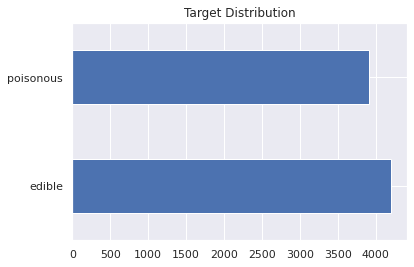

In [11]:
ax = mush_eda["class"].value_counts().plot(kind='barh', title="Target Distribution")

As we can see, the class distribution is relatively balanced, with most mushrooms being edible. Slightly less mushrooms are poisonous. 

#### Features
We will now look at the different features of the mushroom.

##### General Features
There are some features which seem to have similar appearances, and hence may be confused for each other:
- Spore Print Color: Black, Brown and Chocolate
- Odor: Foul, Fishy, Pungent, Musty
- Population: {Several, Scattered}, {Numerous, Abudant, Clustered}
###### Spore Print Color
![](https://github.com/Tien-Cheng/AI-and-Machine-Learning--ST1511-/blob/master/Assignment%201/classification/media/spore_print_capture.PNG?raw=1)
- The spore print is the powdery deposit obtained by allowing spores of the mushroom to fall onto a surface underneath. 
- It is an essential clue to the identity of many species of mushrooms. 
- Individual spores are too small to be visible without a microscope. Hence other techniques must be used to obtain this data.
- One way is to cut off the head of the mushroom, and place it with the gills (below the cap) facing downward on a white sheet of paper. 
- Another way is to look for faint traces of color on the ground from nearby spores. 

###### Bruises
- Bruises are spots of color (usually blue or black) on the mushroom (usually on the underside or stem). 
- We can check for bruises by cutting/scratching off the top and bottom of the cap and observing for any color change.

###### Odor
- An odor is the smell a mushroom gives off. 
- It is usually faint, but may be detected by crushing the flesh between your fingers. 

###### Population & Habitat
![](https://github.com/Tien-Cheng/AI-and-Machine-Learning--ST1511-/blob/master/Assignment%201/classification/media/pop.PNG?raw=1)
- Population refers to the number of mushrooms in the area. Some mushrooms grow in big groups, while some mushrooms are isolated
- Habitat refers to the environment in which the mushroom is found in.

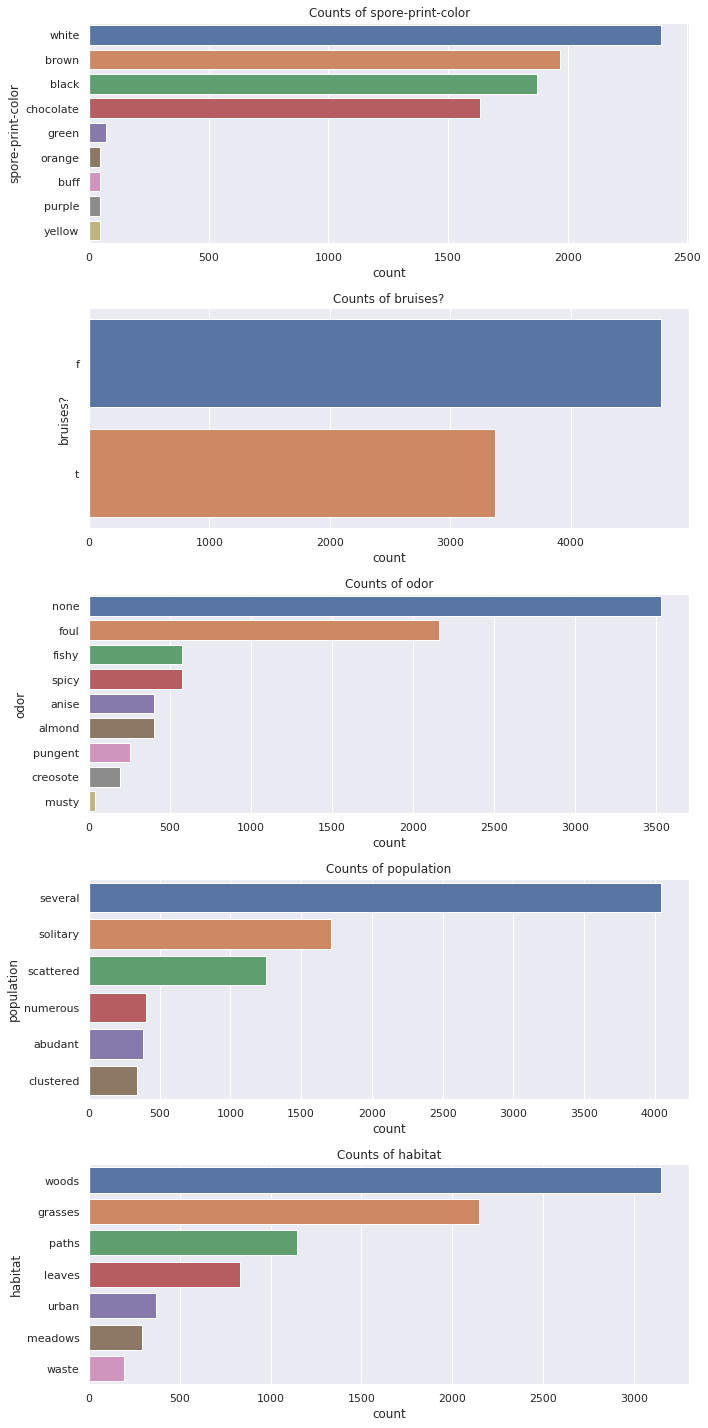

In [12]:
general_features = ['spore-print-color', 'bruises?', 'odor', 'population', 'habitat']

fig = cat_plot(mush_eda, general_features)

fig.show()

We note a few things about the general features of mushrooms:
- Most mushrooms have either white or dark looking spores. 
- Most mushrooms have no odor, and those mushrooms tend to be edible.
- It seems that mushrooms with a bad smell in general would tend to be poisonous
- Most mushrooms grow in the woods, followed by in grass land
- Most mushrooms don't have bruises.


##### Mushroom Caps
The cap is the head, and most visible part of the mushroom.
###### Cap Shape
The cap shapes of gill mushrooms look like this

![](https://github.com/Tien-Cheng/AI-and-Machine-Learning--ST1511-/blob/master/Assignment%201/classification/media/cap_shape.PNG?raw=1)


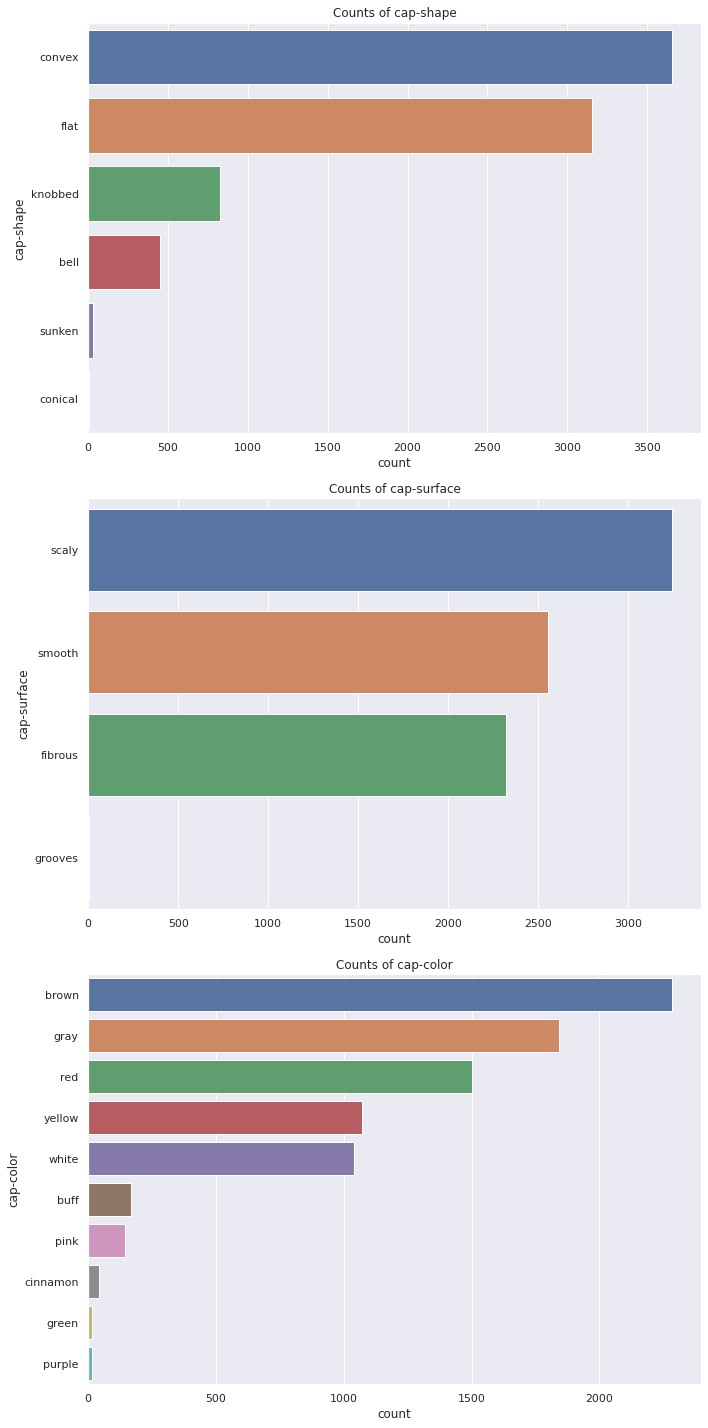

In [13]:
cap_features = ['cap-shape', 'cap-surface', 'cap-color']
fig = cat_plot(mush_eda, cap_features)
fig.show()

- Most mushrooms are convexed shape (round head)
- For cap surface, almost no mushrooms have a grooved surface.
- For most mushrooms, cap color and shape does not seem to have much impact on its edibility as shown by the close porportion of classes for the top most common values
- Most of the unique variations in cap shape and color are relatively distinct in appearance.

##### Gills
- It is the part of the mushroom under the cap.

###### Gill Attachment
Refers to the way in which the gill is attached to the cap.

![](https://www.mushroomexpert.com/images/kuo6/glossary_gills_02.jpg)

###### Gill Spacing
Refers to the space between each gill 

![](https://www.mushroomexpert.com/images/kuo6/glossary_gills_03.jpg)

###### Gill Size
- Refers to the size of each individual gill 


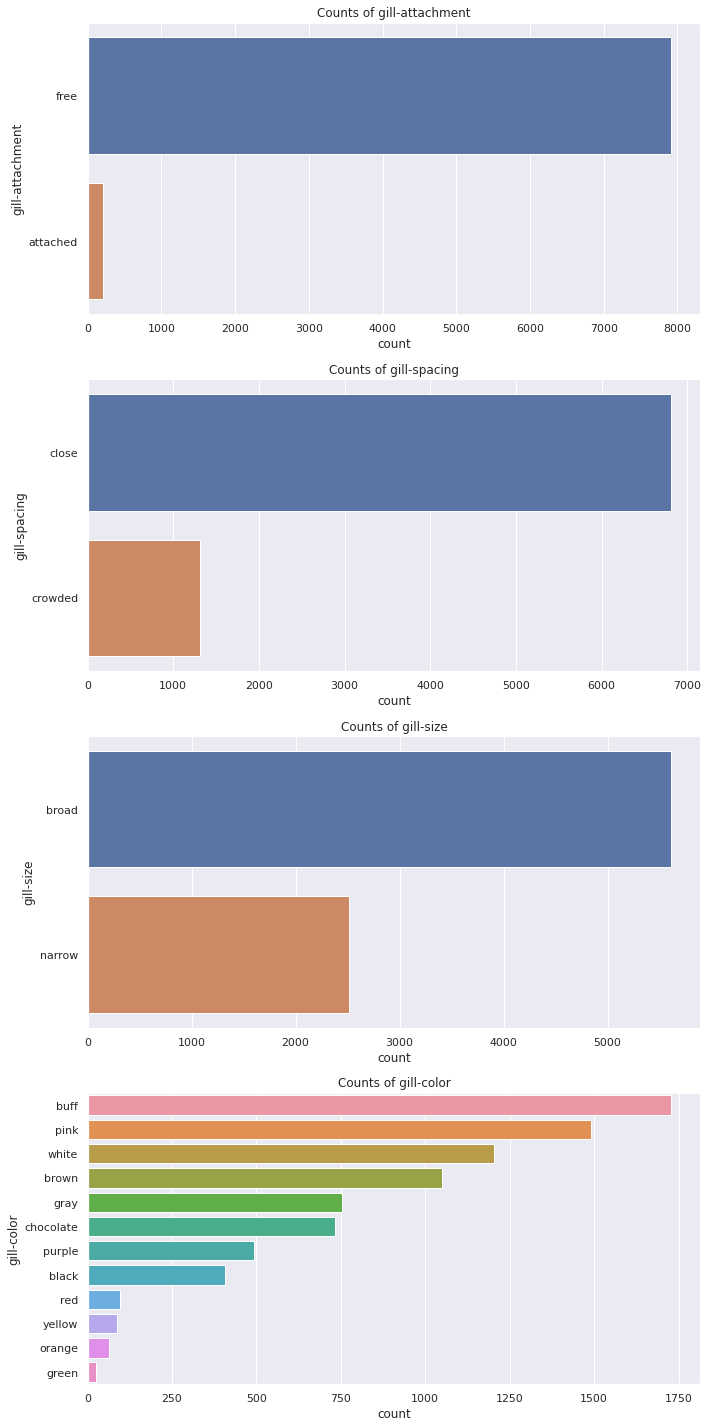

In [14]:
gill_features = ['gill-attachment', 'gill-spacing', 'gill-size', 'gill-color']
fig = cat_plot(mush_eda, gill_features)

fig.show()

- Most gills are attached freely to the cap. Since it can be hard to distinguish whether or not a gill is freely attached or broadly attached, the feature may not be practical to collect in the field
- Similarly, a close and crowded gill spacing may be harder to distinguish.
- Most gills are broad, and close together.
- Most gills have a buff color, which looks similar to yellow.

##### Stalk
###### Stalk Shape
![](https://github.com/Tien-Cheng/AI-and-Machine-Learning--ST1511-/blob/master/Assignment%201/classification/media/stalkshape.PNG?raw=1)

###### Stalk Surface
![](https://github.com/Tien-Cheng/AI-and-Machine-Learning--ST1511-/blob/master/Assignment%201/classification/media/stalk_surface.PNG?raw=1)

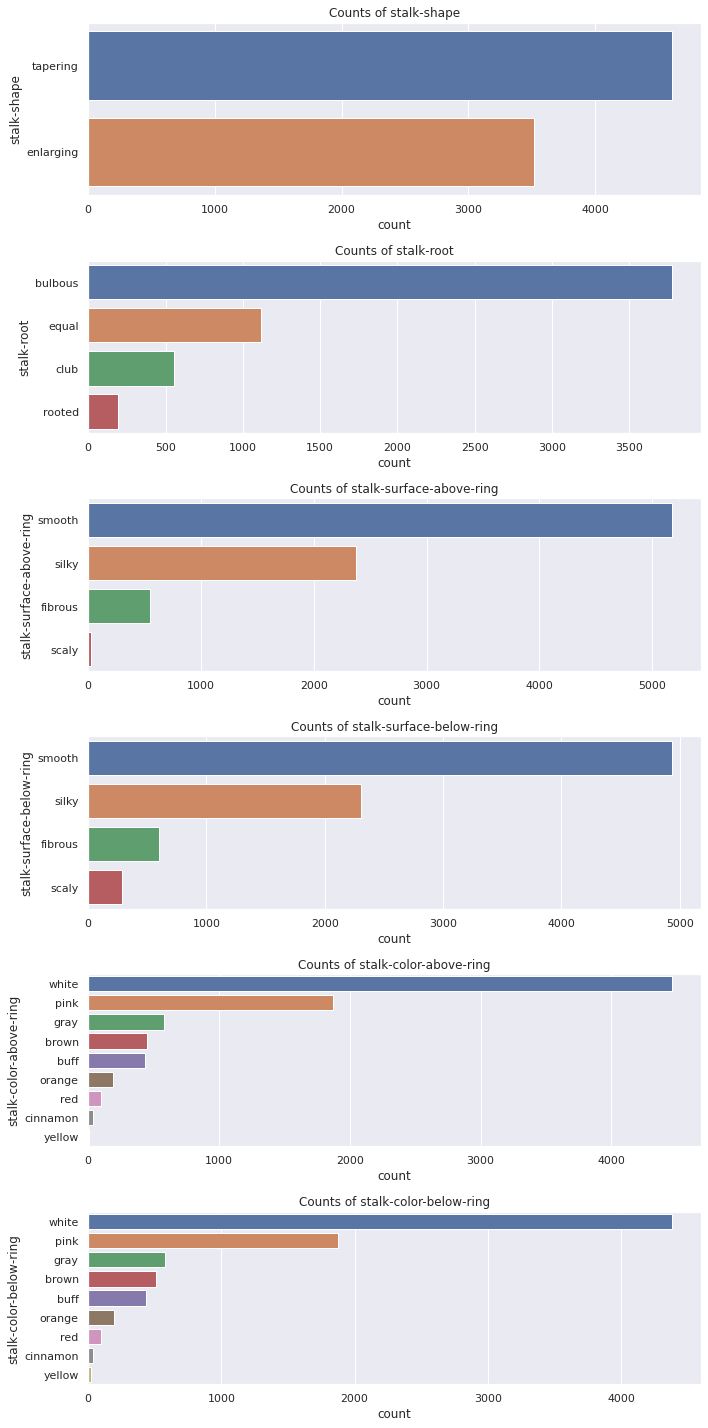

In [15]:
stalk_features = ['stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring']
fig = cat_plot(mush_eda, stalk_features)

fig.show()

- Most mushrooms have a tapering stalk shape
- The roots of most mushrooms are bulbous (resembles a bulb)
- Most stalks have a smooth surface above and below the ring and are white or pink in color

##### Veil
A veil is the part that covers the cap and stalk of an immature mushroom.

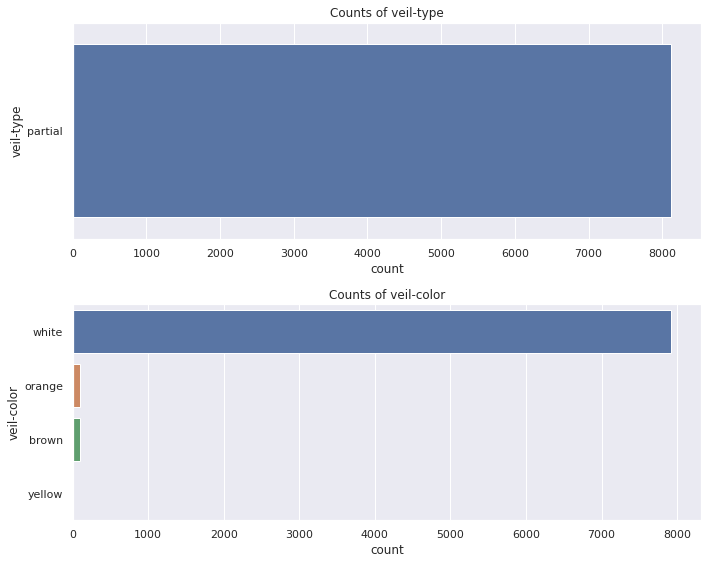

In [16]:
veil_features = ['veil-type', 'veil-color']
fig = cat_plot(mush_eda, veil_features, figsize=(10, 8))

fig.show()

- Veil features are not that interesting, as there is only one type of veil in the data, and most veil are white in color

##### Ring
The ring is a remmant of a partial veil on the stalk.
![](http://ids-mushroom.appspot.com/images/mushroom%20wireframes_Mushroom%20Veils.png)

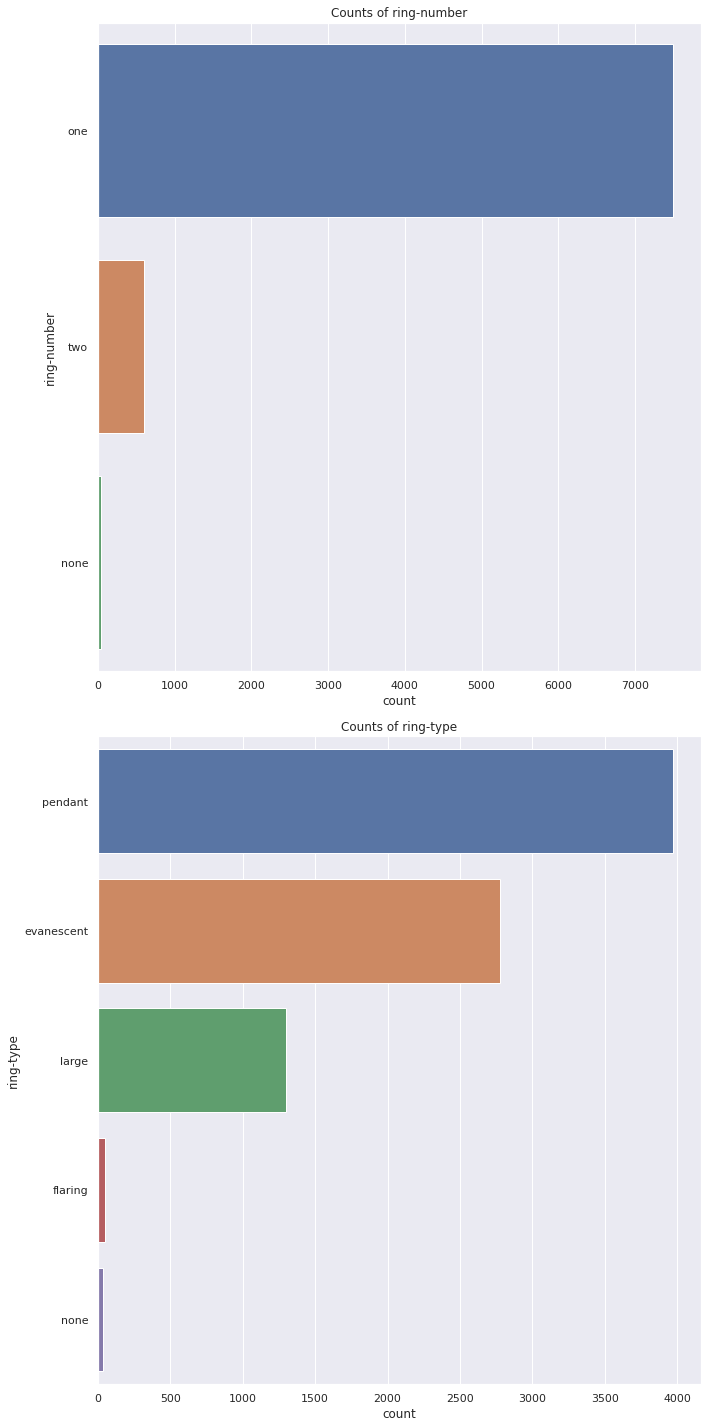

In [17]:
ring_features = ['ring-number',
       'ring-type']
fig = cat_plot(mush_eda, ring_features)

fig.show()

- Most mushrooms have a single ring which comes down from the bottom of the cap (like a pendant)

### Bivariate Analysis
To check correlation between the features and target, we will make use of the Cramers V statistic for categorical-categorical association. It is an extension of Pearson's $\chi^2$ that gives a value between 0 and 1. Since Cramer's V tends to overestimate the strength of association, it is also necessary to apply a bias correction.

Corrected Cramer's V between two categorical variables, $A$ and $B$ is calculated as follows:

1. From $n$ samples, create a $r*k$ contigency table, where $r = $ Number of Levels in A, and $k=$ Number of Levels in B
2. Calculate the $\chi^2$ statistic from the contigency table
3. Let $\varphi^2 = \chi^2/n$, where $\varphi$ is the phi coefficient
4. Let $\tilde{\phi^2} = \max(0, \varphi^2 - \frac{(k-1)(r-1)}{n-1})$, be the bias corrected value of phi
5. Let $\tilde{k} = k - \frac{(k-1)^2}{n-1}$ and $\tilde{r} = r - \frac{(r-1)^2}{n-1}$  
6. Then, corrected Cramer's V can be calculated as follows: 
$$
\tilde{V} = \sqrt{\frac{\tilde{\varphi^2}}{\min(\tilde{k} - 1, \tilde{r} - 1)}}$$


In [18]:
def calculate_cramer_v(df, feature_1, feature_2):
  cross_tab = pd.crosstab(df[feature_1], df[feature_2]) # create a contigency table 
  n, k, r = np.sum(cross_tab.values), cross_tab.shape[0], cross_tab.shape[1]
  if k == 1 or r == 1: # if constant value
    return np.nan
  chi_sq = sp.stats.chi2_contingency(cross_tab)[0] # calculate chi^2 based off the contigency table
  phi_sq = chi_sq / n 
  corrected_phi_sq = max(0, phi_sq - (((k-1)*(r-1)) / (n-1)))
  corrected_k = k - ((k - 1)**2 / (n - 1))
  corrected_r = r - ((r - 1)**2 / (n - 1))
  return np.sqrt(corrected_phi_sq / min(corrected_k - 1, corrected_r - 1))

def cramer_corr_matrix(df):
  features = list(df.columns)
  matrix = np.zeros((len(features), len(features)))
  for i in range(len(features)):
    for j in range(len(features)):
      matrix[i, j] = calculate_cramer_v(df, features[i], features[j])
  return pd.DataFrame(matrix, columns = features, index = features)

In [19]:
corrmatrix = cramer_corr_matrix(mush_eda)
corrmatrix.drop('veil-type', axis = 1, inplace=True)
corrmatrix.drop('veil-type', axis = 0, inplace=True)

In [20]:
sorted_matrix = corrmatrix.sort_values("class", ascending=False)

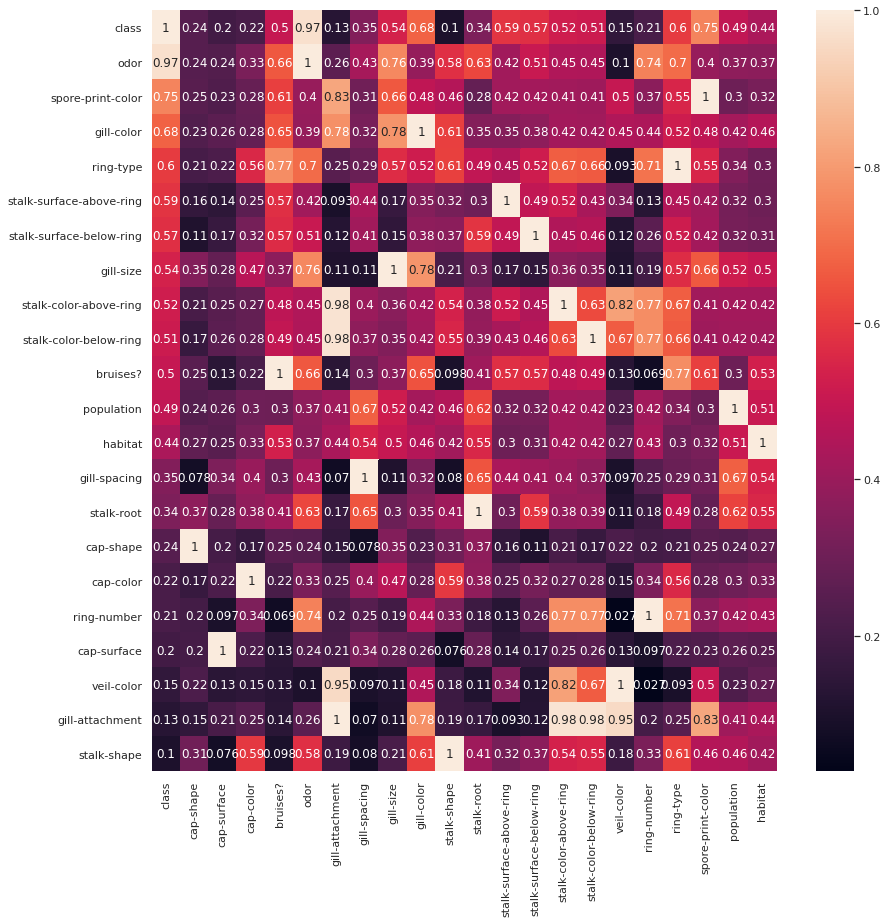

In [21]:
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(sorted_matrix, annot=True, ax = ax)
fig.show()
plt.savefig("corr.png", dpi=600)

Based off the correlation heatmap, we note a few things:
- The features with greatest correlation with class are odor, gill-color, stalk surface, gill size and spore print color 
- Many features are correlated with each other. This suggests there is a lot of redundant information in the data, and that we would benefit from feature selection.

We will investigate the most correlated features, and see how the different values affect the class.

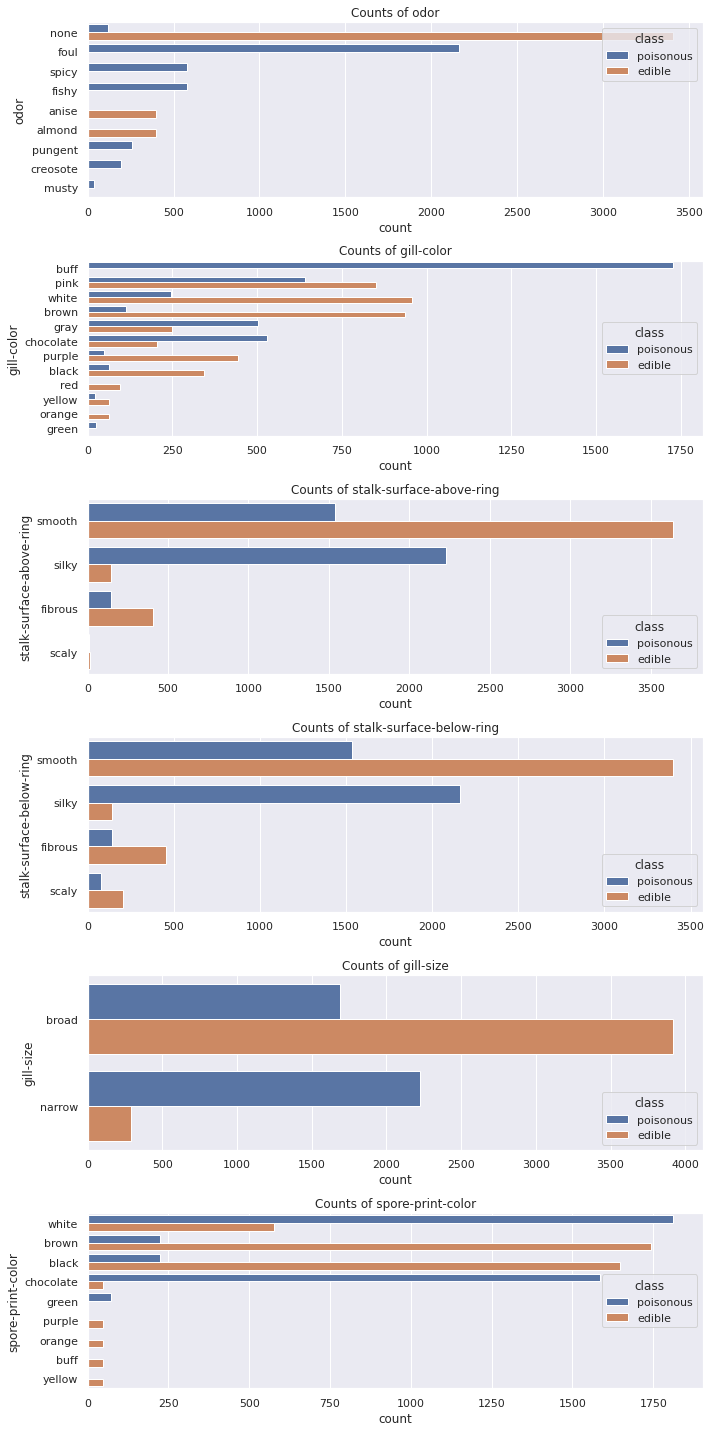

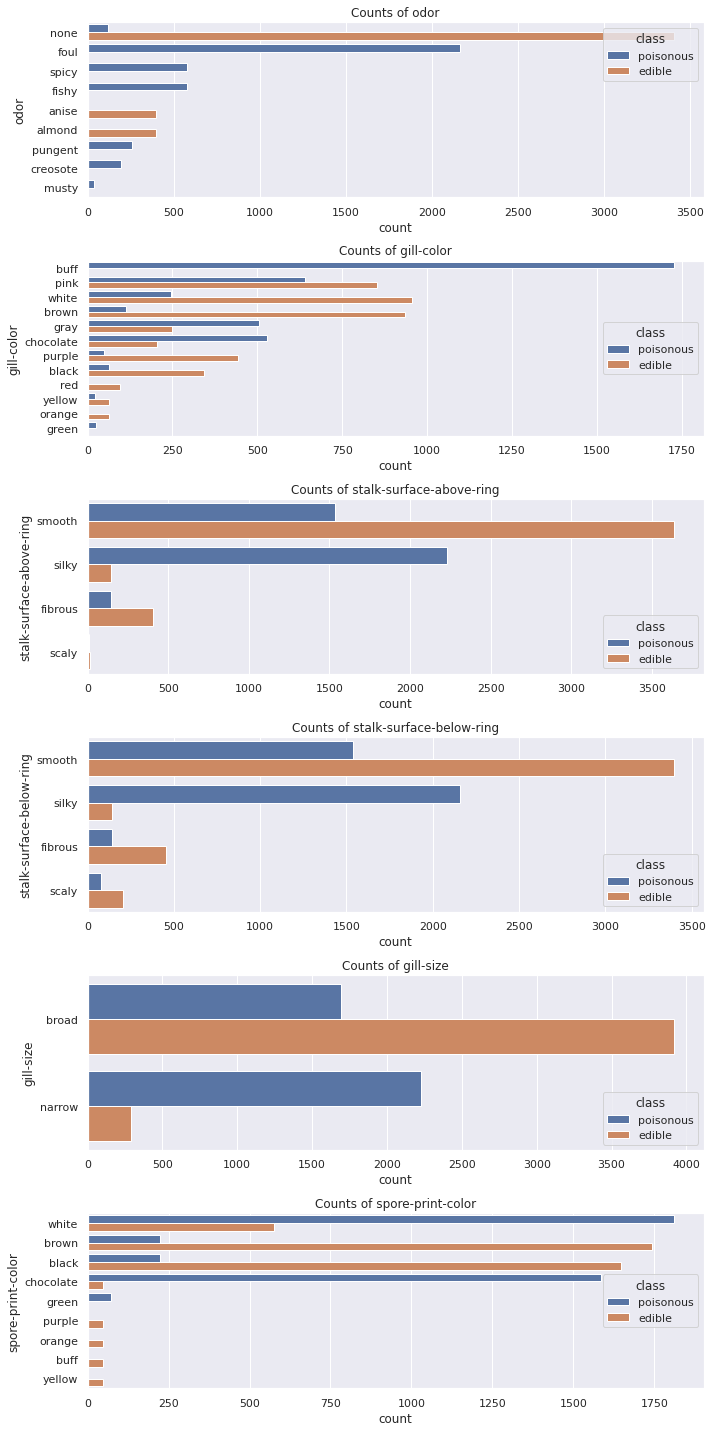

In [10]:
greatest_corr = ["odor", "gill-color", "stalk-surface-above-ring", "stalk-surface-below-ring", "gill-size", "spore-print-color"]
cat_plot(mush_eda, greatest_corr, "class")
plt.show()

We note that:
- No smell seems to be the most likely indicator of a edible mushroom
- Brown, purple and black gilled mushrooms tend to be poisonous
- Most mushrooms with a smooth stalk are poisonous
- Broad gills tend to indicate poison
- White or Chocolate Spores tend to be safe, but black and brown spores tend to be poisonous.

### Missing Value Analysis
During our initial view of the data, we noted that there were missing value for `stalk-root`. We will do some further analysis to investigate the cause of the missing data.

In [22]:
mush_eda["is_missing"] = mush_eda["stalk-root"].isna()

In [23]:
cramer_corr_matrix(mush_eda)["is_missing"].sort_values(ascending=False)

is_missing                  0.999710
spore-print-color           0.929691
gill-color                  0.850809
ring-type                   0.646817
odor                        0.640680
gill-size                   0.601792
habitat                     0.594037
cap-color                   0.506855
population                  0.499297
cap-shape                   0.480141
bruises?                    0.454443
stalk-color-above-ring      0.433056
stalk-color-below-ring      0.432535
cap-surface                 0.368313
ring-number                 0.305420
class                       0.301548
stalk-surface-above-ring    0.239606
veil-color                  0.234759
stalk-surface-below-ring    0.219897
gill-attachment             0.214307
stalk-shape                 0.172730
gill-spacing                0.080605
stalk-root                       NaN
veil-type                        NaN
Name: is_missing, dtype: float64

We note that the presence or absence of a stalk root property is strongly correlated with the gill color and spore-print color. This suggests that the values are not missing at random, but rather indicate some species of mushroom without a stalk-root. 

## Data Preparation
Before we can train a machine learning algorithm on our data, we first need to prepare our data.

### Separate Target Label and Features
We will first separate our target label from the features. It is also necessary to perform a label encoding on the target label to convert it to a number.

In [11]:
X, y = mush_df.drop('class', axis = 1), mush_df["class"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [12]:
list(zip(label_encoder.inverse_transform(y), y))[:4] # 1 corresponds to a poisonous mushroom

[('poisonous', 1), ('edible', 0), ('edible', 0), ('poisonous', 1)]

### Create Hold Out Set
To evaluate our final chosen models, we will leave a small independent test set to report on the final performance of our classifiers. When building the hold out set, we use stratify to ensure that the distribution of classes is the same in both the independent set and the training set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, shuffle=True,random_state = random_state)

### Data Preprocessing Pipeline
We use a scikit-learn pipeline to perform data preprocessing. Using a pipeline helps ensure that there is no data leakage when training and evaluating our models through cross validation.

#### Drop Features
- We choose to drop our stalk root column entirely since there are a large number of missing values.
- We will also drop veil type since it has only a single unique value, and hence has absolute no predictive power

#### Encoding Categorical Columns
- Since all the columns are nominally valued, we will perform one hot encoding on the categorical values.

In [14]:
X_train.drop("stalk-root", axis = 1, inplace=True)
X_test.drop("stalk-root", axis = 1, inplace=True)
X_train.drop("veil-type", axis = 1, inplace=True)
X_test.drop("veil-type", axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
data_preprocess_steps = [
    ('Encoding Categorical Variables', OneHotEncoder(handle_unknown='ignore'))
]

data_preprocess_transformer = Pipeline(data_preprocess_steps)
data_preprocess_transformer.fit_transform(X_train)

<6499x111 sparse matrix of type '<class 'numpy.float64'>'
	with 129980 stored elements in Compressed Sparse Row format>

## Modelling

### Evaluation Methodology
- Given the small size of the dataset in comparison to the number of one hot encoded features, any model used would be highly prone to overfitting.
- We will use a strategy of k-Fold Cross Validation to select our candidate models from the training data
- Then, the final model is evaluated on an independent test set.

We make use of the function below to perform cross validation to evaluate our models.

In [16]:
f2_score = make_scorer(fbeta_score, beta = 2) # define our f2 score
metrics = {
    "f2" : f2_score,
    "accuracy" : "accuracy",
    "recall" : "recall" 
}
def evaluate_candidate_model(clf, X, y, metrics = metrics, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42), model_name = None, history = pd.DataFrame(), return_estimator = False, return_learning_curve = True):
    model_name = model_name if model_name is not None else type(clf).__name__
    scores = cross_validate(clf, X, y, cv = cv, scoring = metrics, return_train_score = True, return_estimator = return_estimator, n_jobs= -1)
    if return_estimator:
        best_estimator = scores["estimator"][np.argmax(scores["test_f2"])]
        del scores["estimator"]
    scores = pd.DataFrame(scores).describe().iloc[1:3, 2:].round(5) # Get Summarized Cross Val Scores
    his_snapshot = scores.iloc[0, :]
    his_snapshot["Standard Error of F2 Score"] = scores["test_f2"].iloc[1] / np.sqrt(cv.get_n_splits())
    his_snapshot["Performance Gap"] = his_snapshot["train_f2"] - his_snapshot["test_f2"]
    his_snapshot.rename(index=model_name, inplace=True)
    history = history.append(his_snapshot)
    if return_learning_curve:
      lr = plot_learning_curve(clf, X, y, scoring=f2_score, cv = cv)
    return scores, history, lr if return_learning_curve else None, best_estimator if return_estimator else None

### Baseline Model
Before starting our model building, we will construct a stupid baseline to compare all other models against. This stupid baseline will predict a random value based on the distribution of classes in the training data. Since our classes are quite balanced this is almost the same as flipping a coin.

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.48677,0.47951,0.50685,0.49823,0.48644,0.47949
std,0.02188,0.00769,0.01565,0.00892,0.02424,0.00761


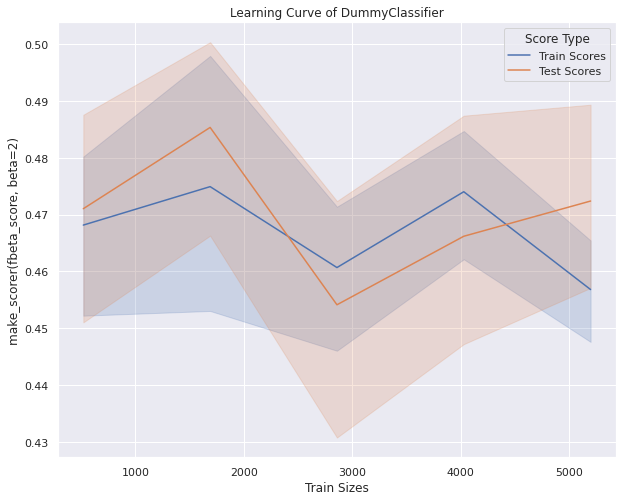

In [17]:
baseline = Pipeline([
    ('Data Preprocessing', data_preprocess_transformer),
    ('Model', DummyClassifier(strategy="stratified"))
])

scores, history, base, _ = evaluate_candidate_model(baseline, X_train, y_train, model_name="Baseline")
display(scores)

Here, we see that the baseline model has a $F_2$ score.

### Logistic Regression

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.99898,0.99968,0.99938,0.99981,0.99872,0.9996
std,0.00229,0.00000,0.00138,0.00000,0.00285,0.0000


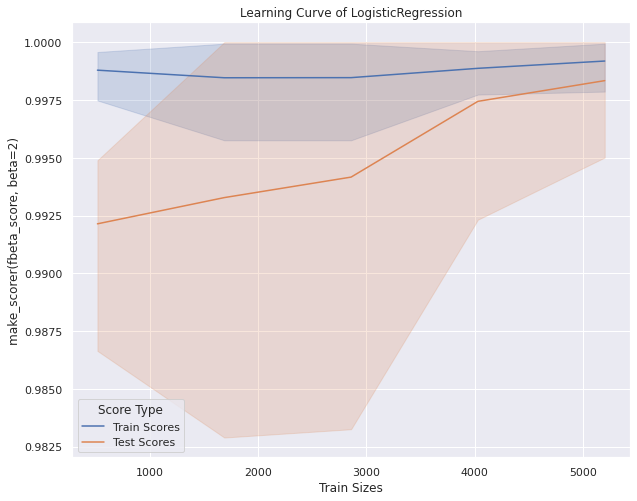

In [18]:
logreg = Pipeline([
    ('Data Preprocessing', data_preprocess_transformer),
    ('Model', LogisticRegression(random_state=random_state))
])

scores, history, lr, _ = evaluate_candidate_model(logreg, X_train, y_train, history=history, model_name="Logistic Regression")
display(scores)

A logistic regression model performs very well on our data, as shown by the close gap between the training and validation folds. It seems that the model has a low bias and low variance, making it a good candidate for our final model.

### Decision Tree

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.99949,1.0,0.99969,1.0,0.99936,1.0
std,0.00114,0.0,0.00069,0.0,0.00143,0.0


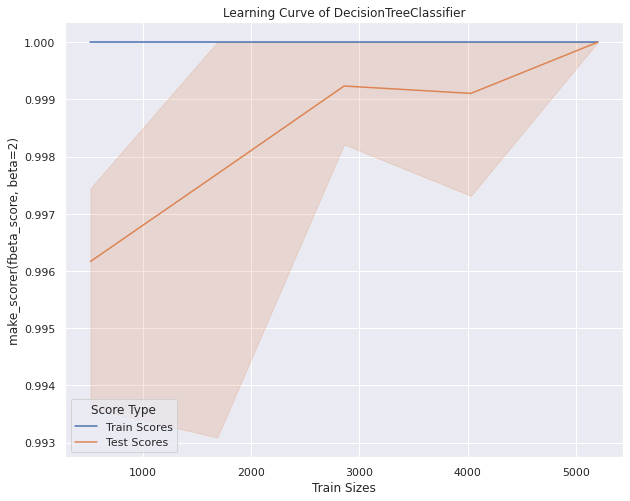

In [19]:
dt = Pipeline([
    ('Data Preprocessing', data_preprocess_transformer),
    ('Model', DecisionTreeClassifier(random_state=random_state))
])

scores, history, lr, _ = evaluate_candidate_model(dt, X_train, y_train, history=history, model_name="Decision Tree")
display(scores)

We see that the decision tree classifer performs even better than our Logistic Regression model. It has a perfect score on the training data, and nearly perfect score on test sets.

### K Nearest Neighbours

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.99974,1.0,0.99985,1.0,0.99968,1.0
std,0.00057,0.0,0.00034,0.0,0.00071,0.0


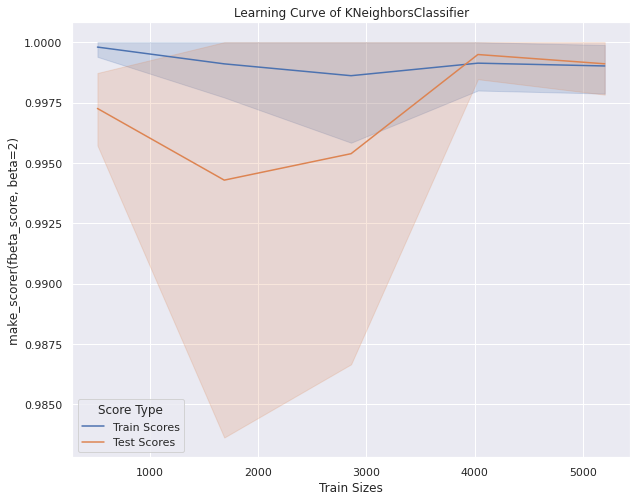

In [22]:
knn = Pipeline([
    ('Data Preprocessing', data_preprocess_transformer),
    ('Model', KNeighborsClassifier())
])

scores, history, lr, _ = evaluate_candidate_model(knn, X_train, y_train, history=history, model_name="KNN")
display(scores)

A KNN Model performs surprisingly well, with a F2 score comparable to Decision Trees, but it takes up a lot of memory due to the high dimensionality of our data, making it rather impractical. Since it is also harder to interpret a KNN model, it is not really suited for our problem despite its good performance.

### Categorical Naive Bayes
To use categorical native bayes, we first need to ordinally encode our data. The algorithm will still treat the variables as nominal variables, but they still need to be encoded as numbers for the model to be fitted.

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.93017,0.93228,0.95676,0.95830,0.91542,0.91773
std,0.01526,0.00223,0.00931,0.00127,0.01816,0.00273


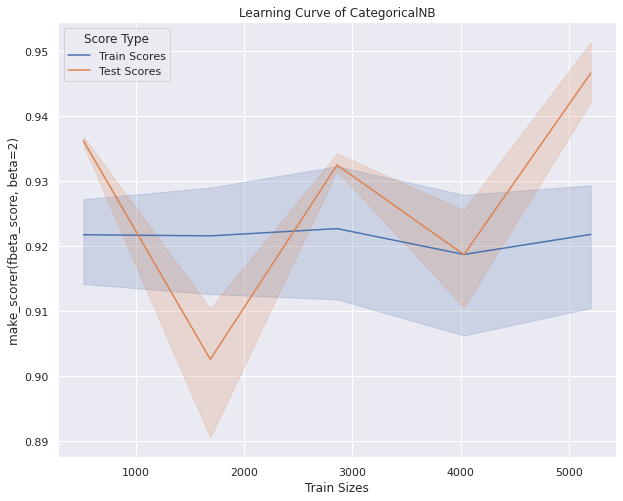

In [24]:
nb = Pipeline([
    ('Data Preprocessing', OrdinalEncoder()),
    ('Model', CategoricalNB())
])
scores, history, lr, _ = evaluate_candidate_model(nb, X_train, y_train, history=history, model_name="Categorical NB")
display(scores)

CategoricalNB trains extremely quickly, but has disappointing performance, with a test F2 score of 0.93, weaker than other models like Logistic Regression.

### Support Vector Machines

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.99898,0.99994,0.99938,0.99996,0.99872,0.99992
std,0.00229,0.00014,0.00138,0.00009,0.00285,0.00018


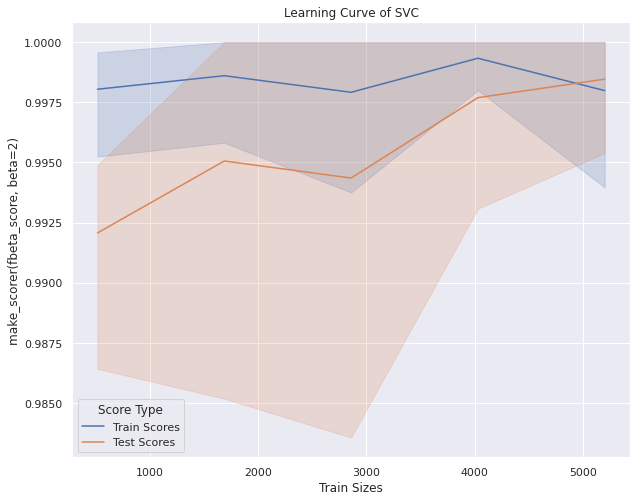

In [25]:
svm = Pipeline([
    ('Data Preprocessing', data_preprocess_transformer),
    ('Model', SVC(random_state=random_state))
])

scores, history, lr, _ = evaluate_candidate_model(svm, X_train, y_train, history=history, model_name="Support Vector Classifier")
display(scores)

A support vector machine seems to do well, and does not seem to overfit as heavily as other models. 

## Model Selection

In [26]:
history.sort_values(["test_f2", "Performance Gap"], ascending=[False, True])

,Performance Gap,Standard Error of F2 Score,test_accuracy,test_f2,test_recall,train_accuracy,train_f2,train_recall
KNN,0.00026,0.000255,0.99985,0.99974,0.99968,1.00000,1.00000,1.00000
Decision Tree,0.00051,0.000510,0.99969,0.99949,0.99936,1.00000,1.00000,1.00000
Logistic Regression,0.00070,0.001024,0.99938,0.99898,0.99872,0.99981,0.99968,0.99960
Support Vector Classifier,0.00096,0.001024,0.99938,0.99898,0.99872,0.99996,0.99994,0.99992
Categorical NB,0.00211,0.006824,0.95676,0.93017,0.91542,0.95830,0.93228,0.91773
Baseline,-0.00726,0.009785,0.50685,0.48677,0.48644,0.49823,0.47951,0.47949


In terms of performance, KNN seems to perform the best, but the model is not as easily interpretible as the other models, and is memory intensive. It is also likely overfitting the data as the data is very sparse.

Decision Trees and Logistic Regression perform very well on our data. While the SVM has similar performance to Logistic Regression, the model shows more signs of overfitting than Logistic Regression, due to the gap in performance between the training folds and cross validation folds being larger.

We will thus attempt to improve upon the Decision Tree and Logistic Regression model.

## Model Improvement
Although our models perform very well, there are still some improvements to be made to our models by simplifying them to make them more generalizable.

In [27]:
model_improvement_hist = history.copy()

### Encoding Methodology

One problem our data faces is it's high dimensionality. This is due to every feature being a categorical variable, some with high cardinality. This results in a problem known as the curse of dimensionality, where our models have a tendency to overfit the data.

In addition, there are some practical considerations to be made. During our EDA, we found that certain features of the mushrooms (levels in each of the categorical variables), had values that could easily be mistaken for each other. For example, a buff color is very similar to yellow. Hence, if this model is to be deployed, it makes sense to merge these values together, since the end user may have difficulty distinguishing between these values. 

Hence, we will attempt a method to solve both of these problems. We will:
- binary encode categorical variables with only 2 unique values
- one hot encode the rest
- after one hot encoding, merge those categories that look similar to each other, based on our existing background research

To do this, we implement a custom transformer in scikit learn which will fit a one hot encoder and merge certain features together.

In [28]:
merging_dict = {
    "spore-print-color_yellowlike" : ["spore-print-color_yellow", "spore-print-color_buff"], # yellow and buff look very similar
    "spore-print-color_brownlike" : ["spore-print-color_brown", "spore-print-color_chocolate"],
    "odor_badsmell" : ["odor_foul", "odor_fishy", "odor_pungent", "odor_musty"],
    "population_many_or_clustered" : ["population_numerous", "population_abudant"],
    "gill-color_yellowlike" : ["gill-color_buff", "gill-color_yellow"],
    "gill-color_brownlike" : ["gill-color_brown", "gill-color_chocolate"], 
    "cap-color_brownlike" : ["cap-color_brown", "cap-color_cinnamon"],
    "cap-color_yellowlike" : ["cap-color_yellow", "cap-color_buff"],
    "stalk-color-above-ring_yellowlike" : ["stalk-color-above-ring_yellow", "stalk-color-above-ring_buff"],
    "stalk-color-above-ring_brownlike" : ["stalk-color-above-ring_brown", "stalk-color-above-ring_cinnamon"],
    "stalk-color-below-ring_yellowlike" : ["stalk-color-below-ring_yellow", "stalk-color-below-ring_buff"],
    "stalk-color-below-ring_brownlike" : ["stalk-color-below-ring_brown", "stalk-color-below-ring_cinnamon"],

}
class CustomOHE(BaseEstimator, TransformerMixin):
  def __init__(self, merging_dict, features = None):
    self.merging_dict = merging_dict
    self.features = features
    self.ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
  def fit(self, X, y=None):
    self.ohe.fit(X)
    if self.features is None:
      self.features = X.columns
    self.ohe_features = self.ohe.get_feature_names(self.features)
    return self
  def transform(self, X, y=None):
    X_ = self.ohe.transform(X)
    X_ = pd.DataFrame(X_, columns = self.ohe_features)
    for merged_name, to_merge in self.merging_dict.items():
      value = np.logical_or.reduce([X_[col] for col in to_merge]).astype(float)
      X_[merged_name] = value
      X_.drop(to_merge, axis = 1, inplace=True)
    self.features_after_merge = X_.columns
    return X_
  def get_feature_names(self, features = None):
    return self.features_after_merge

In [29]:
X_train.describe().T.sort_values("unique")

,count,unique,top,freq
stalk-shape,6499,2,tapering,3678
bruises?,6499,2,f,3795
gill-attachment,6499,2,free,6337
gill-spacing,6499,2,close,5456
gill-size,6499,2,broad,4518
ring-number,6499,3,one,5985
cap-surface,6499,4,scaly,2570
veil-color,6499,4,white,6345
stalk-surface-below-ring,6499,4,smooth,3936
stalk-surface-above-ring,6499,4,smooth,4143


We take note of which features have only two unique values

In [31]:
def get_feature_names(col_transformer): # a function that automatically gets us the one hot encoded feature names
  cols = [(transformer, columns) for (name, transformer, columns) in col_transformer.transformers_]
  return np.concatenate([(transformer.get_feature_names(columns)) for (transformer, columns) in cols]).ravel().tolist()

In [33]:
binary_columns = ["bruises?", "gill-attachment", "gill-spacing", "gill-size", "stalk-shape"]
other_columns = [col for col in X_train.columns if col not in binary_columns]

cat_encoder = ColumnTransformer([
                                 ("Binary Encode", OneHotEncoder(drop="first"), binary_columns),
                                 ("One Hot Encode and Merge", CustomOHE(merging_dict, other_columns), other_columns)
])

And define a column transformer to process our data

In [34]:
pd.DataFrame(cat_encoder.fit_transform(X_train), columns=get_feature_names(cat_encoder)).head()

,bruises?_t,gill-attachment_free,gill-spacing_crowded,gill-size_narrow,stalk-shape_tapering,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,cap-color_white,odor_almond,odor_anise,odor_creosote,odor_none,odor_spicy,gill-color_black,gill-color_gray,gill-color_green,gill-color_orange,gill-color_pink,gill-color_purple,gill-color_red,gill-color_white,stalk-surface-above-ring_fibrous,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_fibrous,stalk-surface-below-ring_scaly,...,veil-color_brown,veil-color_orange,veil-color_white,veil-color_yellow,ring-number_none,ring-number_one,ring-number_two,ring-type_evanescent,ring-type_flaring,ring-type_large,ring-type_none,ring-type_pendant,spore-print-color_black,spore-print-color_green,spore-print-color_orange,spore-print-color_purple,spore-print-color_white,population_clustered,population_scattered,population_several,population_solitary,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,spore-print-color_yellowlike,spore-print-color_brownlike,odor_badsmell,population_many_or_clustered,gill-color_yellowlike,gill-color_brownlike,cap-color_brownlike,cap-color_yellowlike,stalk-color-above-ring_yellowlike,stalk-color-above-ring_brownlike,stalk-color-below-ring_yellowlike,stalk-color-below-ring_brownlike
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


,Performance Gap,Standard Error of F2 Score,test_accuracy,test_f2,test_recall,train_accuracy,train_f2,train_recall
Baseline,-0.00726,0.009785,0.50685,0.48677,0.48644,0.49823,0.47951,0.47949
Logistic Regression,0.00070,0.001024,0.99938,0.99898,0.99872,0.99981,0.99968,0.99960
Decision Tree,0.00051,0.000510,0.99969,0.99949,0.99936,1.00000,1.00000,1.00000
KNN,0.00026,0.000255,0.99985,0.99974,0.99968,1.00000,1.00000,1.00000
Categorical NB,0.00211,0.006824,0.95676,0.93017,0.91542,0.95830,0.93228,0.91773
Support Vector Classifier,0.00096,0.001024,0.99938,0.99898,0.99872,0.99996,0.99994,0.99992
LogisticRegression (Improved Encoding),0.00064,0.000988,0.99923,0.99872,0.99840,0.99962,0.99936,0.99920
DecisionTreeClassifier (Improved Encoding),0.00000,0.000000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


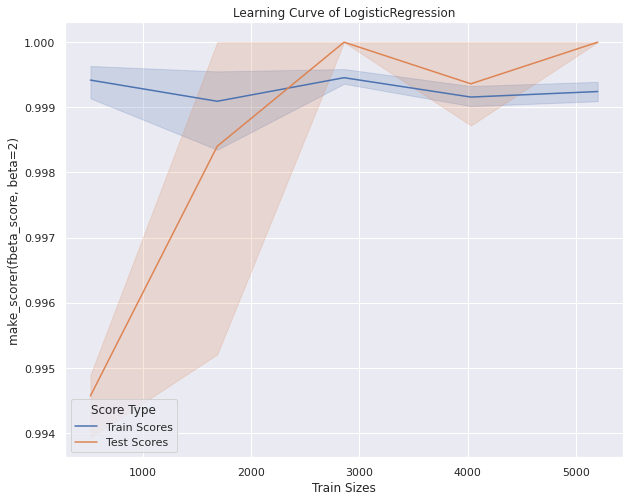

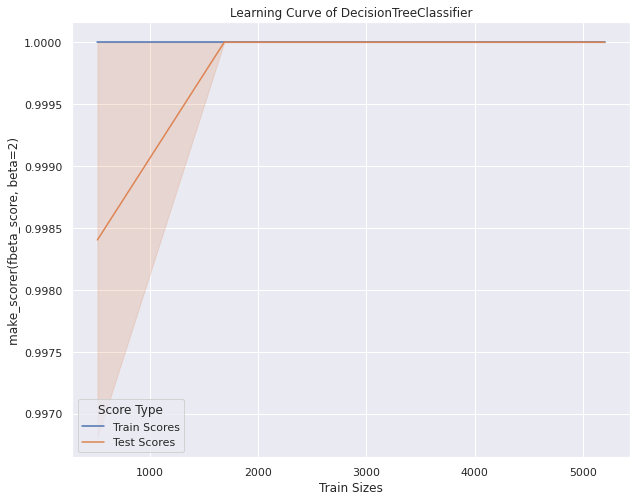

In [35]:
models = [LogisticRegression(random_state=random_state), DecisionTreeClassifier(random_state=random_state)]
for model in tqdm(models):
    model_name = type(model).__name__
    model = Pipeline([
        ('Data Preprocessing', cat_encoder),
        ('Model', model)
    ])
    scores, model_improvement_hist, lr, _ = evaluate_candidate_model(model, X_train, y_train, history= model_improvement_hist, model_name=f"{model_name} (Improved Encoding)", return_learning_curve=True)

display(model_improvement_hist)

In [36]:
model_improvement_hist.sort_values(["test_f2", "Performance Gap"], ascending=[False, True])

,Performance Gap,Standard Error of F2 Score,test_accuracy,test_f2,test_recall,train_accuracy,train_f2,train_recall
DecisionTreeClassifier (Improved Encoding),0.00000,0.000000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
KNN,0.00026,0.000255,0.99985,0.99974,0.99968,1.00000,1.00000,1.00000
Decision Tree,0.00051,0.000510,0.99969,0.99949,0.99936,1.00000,1.00000,1.00000
Logistic Regression,0.00070,0.001024,0.99938,0.99898,0.99872,0.99981,0.99968,0.99960
Support Vector Classifier,0.00096,0.001024,0.99938,0.99898,0.99872,0.99996,0.99994,0.99992
LogisticRegression (Improved Encoding),0.00064,0.000988,0.99923,0.99872,0.99840,0.99962,0.99936,0.99920
Categorical NB,0.00211,0.006824,0.95676,0.93017,0.91542,0.95830,0.93228,0.91773
Baseline,-0.00726,0.009785,0.50685,0.48677,0.48644,0.49823,0.47951,0.47949


We see that our results appear to have been largely successful. While there is some impact to the performance of the Logistic Regression model, it is minor, and we have successfully reduced the dimensionality of our data. In fact, we have managed to improve the score for our Decision Tree classifier.

### Feature Selection
While our encoding methodology has reduced the dimensionality of our data, we still have 95 features in our data. This means our models would be prone to overfitting. Hence, we want to reduce the dimensionality of our data through feature selection.

#### Lasso Regularization
We will attempt to apply an L1 penalty on our Logistic Regression model to automatically select features through L1 Regularization.

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.99898,0.99994,0.99938,0.99996,0.99872,0.99992
std,0.00229,0.00014,0.00138,0.00009,0.00285,0.00018


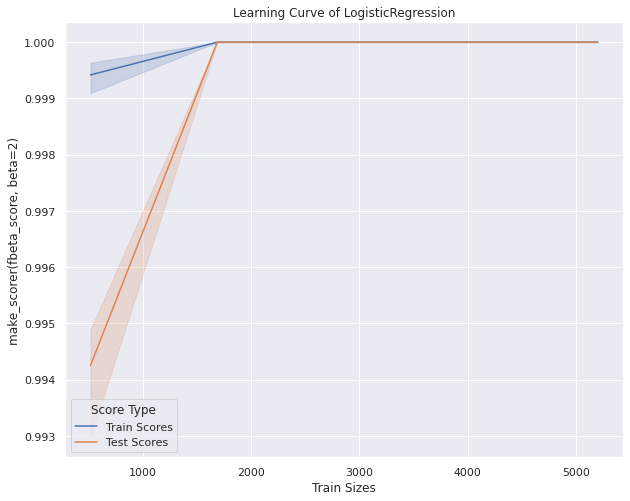

In [37]:
logreg = Pipeline([
    ('Data Preprocessing', cat_encoder),
    ('Model', LogisticRegression(penalty="l1",solver="liblinear",random_state=random_state))
])

scores, model_improvement_hist, lr, l1_logreg = evaluate_candidate_model(logreg, X_train, y_train, history=model_improvement_hist, model_name="Logistic Regression (L1 Regularization)", return_estimator=True)
display(scores)

In [38]:
features = get_feature_names(cat_encoder)

In [39]:
selected_features = [feature for feature, coef in zip(features, l1_logreg[-1].coef_.flatten()) if coef != 0]
removed_features = set(features) - set(selected_features)

In [41]:
selected_features

['gill-spacing_crowded',
 'gill-size_narrow',
 'cap-surface_fibrous',
 'cap-surface_grooves',
 'cap-color_white',
 'odor_almond',
 'odor_anise',
 'odor_creosote',
 'odor_none',
 'stalk-surface-above-ring_silky',
 'stalk-surface-above-ring_smooth',
 'stalk-surface-below-ring_fibrous',
 'stalk-surface-below-ring_scaly',
 'ring-number_two',
 'spore-print-color_green',
 'spore-print-color_white',
 'population_clustered',
 'population_solitary',
 'spore-print-color_brownlike',
 'odor_badsmell',
 'gill-color_yellowlike',
 'cap-color_brownlike',
 'stalk-color-below-ring_yellowlike']

In [42]:
len(removed_features)

69

In [43]:
len(selected_features)

23

We see that Lasso has shrunk our number of features down to 23 features, while retaining a high $F_2$ score.

#### Selecting Via Model Coefficients
To reduce the number of features in our data, we make use of an L1 Regularized Logistic Regression model, which produces a set of sparse coefficients, which we've seen is successful in greatly reducing the dimensionality of our data, while retaining the model performance. We then use the coeffients from the model to perform feature selection for our Decision Tree.

In [44]:
models = [DecisionTreeClassifier(random_state=random_state)]
for model in tqdm(models):
    model_name = type(model).__name__
    model = Pipeline([
        ('Data Preprocessing', cat_encoder),
        ('Feature Selection', SelectFromModel(LogisticRegression(penalty="l1",solver="liblinear",random_state=random_state))),
        ('Model', model)
    ])
    scores, model_improvement_hist, lr, dt_lassofs = evaluate_candidate_model(model, X_train, y_train, history= model_improvement_hist, model_name=f"{model_name} (Sparse Coefficients)", return_learning_curve=False, return_estimator = True)

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


We note that after performing feature selection, our decision tree models maintain their perfect $F_2$ score.

In [45]:
model_improvement_hist.sort_values(["test_f2", "Performance Gap"], ascending=[False, True])

,Performance Gap,Standard Error of F2 Score,test_accuracy,test_f2,test_recall,train_accuracy,train_f2,train_recall
DecisionTreeClassifier (Improved Encoding),0.00000,0.000000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
DecisionTreeClassifier (Sparse Coefficients),0.00000,0.000000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
KNN,0.00026,0.000255,0.99985,0.99974,0.99968,1.00000,1.00000,1.00000
Decision Tree,0.00051,0.000510,0.99969,0.99949,0.99936,1.00000,1.00000,1.00000
Logistic Regression,0.00070,0.001024,0.99938,0.99898,0.99872,0.99981,0.99968,0.99960
Support Vector Classifier,0.00096,0.001024,0.99938,0.99898,0.99872,0.99996,0.99994,0.99992
Logistic Regression (L1 Regularization),0.00096,0.001024,0.99938,0.99898,0.99872,0.99996,0.99994,0.99992
LogisticRegression (Improved Encoding),0.00064,0.000988,0.99923,0.99872,0.99840,0.99962,0.99936,0.99920
Categorical NB,0.00211,0.006824,0.95676,0.93017,0.91542,0.95830,0.93228,0.91773
Baseline,-0.00726,0.009785,0.50685,0.48677,0.48644,0.49823,0.47951,0.47949


### Hyperparameter Tuning

To further simplify our models, we attempt a hyperparameter search on Decision Trees and Logistic Regression, to see if any further improvements can be made.

#### Decision Trees

In [48]:
dt = Pipeline([
        ('Data Preprocessing', cat_encoder),
        ('Feature Selection', SelectFromModel(LogisticRegression(penalty="l1",solver="liblinear",random_state=random_state))),
        ('Model', DecisionTreeClassifier(random_state=random_state))
    ])
param_grid = {
    "Model__max_features" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
    "Model__max_depth" : [2, 3, 4, 5, 6, 7],
    "Model__min_samples_split" : np.linspace(2, 50, dtype=int),
}

dt_rs = RandomizedSearchCV(dt, param_grid, n_iter=200, scoring=f2_score, random_state = random_state)

In [49]:
scores, model_improvement_hist, lr, dt_rs = evaluate_candidate_model(dt_rs, X_train, y_train, history=model_improvement_hist, model_name="Decision Tree (hyperparameter tuning)", return_estimator=True, return_learning_curve=False)
display(scores)

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,1.0,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
dt_rs.best_params_

{'Model__max_depth': 7,
 'Model__max_features': None,
 'Model__min_samples_split': 4}

```
{'Model__max_depth': 7,
 'Model__max_features': None,
 'Model__min_samples_split': 4}
 ```

#### Logistic Regression

In [51]:
logreg = Pipeline([
        ('Data Preprocessing', cat_encoder),
        ('Model', LogisticRegression(solver='liblinear', random_state=random_state))
    ])
param_grid = {
    "Model__penalty" : ["l1", "l2"],
    "Model__C" : np.logspace(-3, 1, base=2)
}

logreg_gs = GridSearchCV(logreg, param_grid, scoring=f2_score)

In [52]:
scores, model_improvement_hist, lr, logreg_gs = evaluate_candidate_model(logreg_gs, X_train, y_train, history=model_improvement_hist, model_name="Logistic Regression (hyperparameter tuning)", return_estimator=True, return_learning_curve=False)
display(scores)

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.99821,0.99968,0.99892,0.99981,0.99777,0.99960
std,0.00333,0.00055,0.00201,0.00033,0.00416,0.00069


In [53]:
model_improvement_hist.sort_values("test_f2")

,Performance Gap,Standard Error of F2 Score,test_accuracy,test_f2,test_recall,train_accuracy,train_f2,train_recall
Baseline,-0.00726,0.009785,0.50685,0.48677,0.48644,0.49823,0.47951,0.47949
Categorical NB,0.00211,0.006824,0.95676,0.93017,0.91542,0.95830,0.93228,0.91773
Logistic Regression (hyperparameter tuning),0.00147,0.001489,0.99892,0.99821,0.99777,0.99981,0.99968,0.99960
LogisticRegression (Improved Encoding),0.00064,0.000988,0.99923,0.99872,0.99840,0.99962,0.99936,0.99920
Logistic Regression,0.00070,0.001024,0.99938,0.99898,0.99872,0.99981,0.99968,0.99960
Support Vector Classifier,0.00096,0.001024,0.99938,0.99898,0.99872,0.99996,0.99994,0.99992
Logistic Regression (L1 Regularization),0.00096,0.001024,0.99938,0.99898,0.99872,0.99996,0.99994,0.99992
Decision Tree,0.00051,0.000510,0.99969,0.99949,0.99936,1.00000,1.00000,1.00000
KNN,0.00026,0.000255,0.99985,0.99974,0.99968,1.00000,1.00000,1.00000
DecisionTreeClassifier (Improved Encoding),0.00000,0.000000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


We see that Logistic Regression does not benefit from hyperparameter tuning, and has no significant change in score after tuning.

However, we've managed to further simpifly the Decision Tree model through hyperparameter tuning, whilst maintaining the same score.

## Final Model
For our final model, we will pick the tuned Decision Tree classifier over Logistic Regression

Our reasons for picking this model is:
- It has achieved the highest $F_2$ score on cross validation
- It is more easily interpretible, as the entire decision tree can be vizualized. 

Our final model used will be a decision tree as shown below. We will fit the model to the entire training data, and evalulate it on the independent test set.

In [54]:
dt = Pipeline([
        ('Data Preprocessing', cat_encoder),
        ('Feature Selection', SelectFromModel(LogisticRegression(penalty="l1",solver="liblinear",random_state=random_state))),
        ('Model', DecisionTreeClassifier(max_depth=7, max_features=None, min_samples_split=4,random_state=random_state))
    ])
dt.fit(X_train, y_train)

Pipeline(steps=[('Data Preprocessing',
                 ColumnTransformer(transformers=[('Binary Encode',
                                                  OneHotEncoder(drop='first'),
                                                  ['bruises?',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-size',
                                                   'stalk-shape']),
                                                 ('One Hot Encode and Merge',
                                                  CustomOHE(features=['cap-shape',
                                                                      'cap-surface',
                                                                      'cap-color',
                                                                      'odor',
                                                                      'gill-color',
                                           

In [55]:
selected_features = [feature for feature, support in zip(features, dt[-2].get_support().flatten()) if support]
removed_features = set(features) - set(selected_features)

In [56]:
selected_features

['gill-spacing_crowded',
 'gill-size_narrow',
 'cap-shape_convex',
 'cap-surface_fibrous',
 'cap-surface_grooves',
 'cap-color_white',
 'odor_almond',
 'odor_anise',
 'odor_creosote',
 'odor_none',
 'stalk-surface-above-ring_silky',
 'stalk-surface-above-ring_smooth',
 'stalk-surface-below-ring_fibrous',
 'stalk-surface-below-ring_scaly',
 'ring-number_two',
 'spore-print-color_green',
 'spore-print-color_white',
 'population_clustered',
 'population_solitary',
 'habitat_waste',
 'spore-print-color_brownlike',
 'odor_badsmell',
 'gill-color_yellowlike',
 'cap-color_brownlike',
 'stalk-color-below-ring_yellowlike']

### Model Evaluation
Finally, we evaluate our model on an indepedent test set, to see if our chosen model is able to generalize to unseen examples.

In [63]:
y_test.shape

(1625,)

There are 1625 unseen test examples.

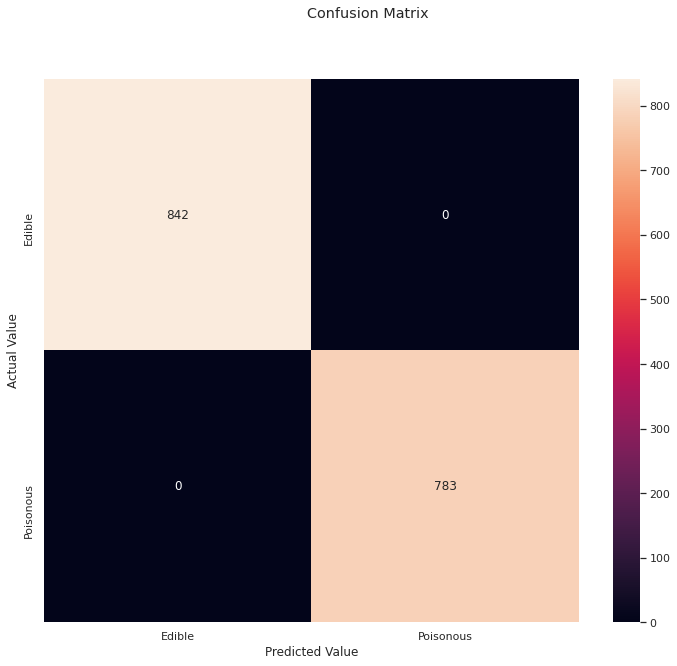

In [57]:
fig, ax = plt.subplots(figsize=(12, 10))
y_pred =dt.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", ax=ax)
ax.set_ylabel("Actual Value")
ax.set_xlabel("Predicted Value")
ax.set_xticklabels(["Edible", "Poisonous"])
ax.set_yticklabels(["Edible", "Poisonous"])
fig.suptitle("Confusion Matrix")
plt.savefig("confusion_matrix_mush.png", dpi=600)

We see that our model has perfectly classified everything in the data, showing it is able to generalize to new data.

In [58]:
print(classification_report(y_test, y_pred, target_names=["Edible", "Poisonous"]))

              precision    recall  f1-score   support

      Edible       1.00      1.00      1.00       842
   Poisonous       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [62]:
print("F2 Score:", f2_score(dt, X_test, y_test))

F2 Score: 1.0


### Feature Importances
Now, to better understand how our model makes decisions, we will plot the feature importances of our decision tree

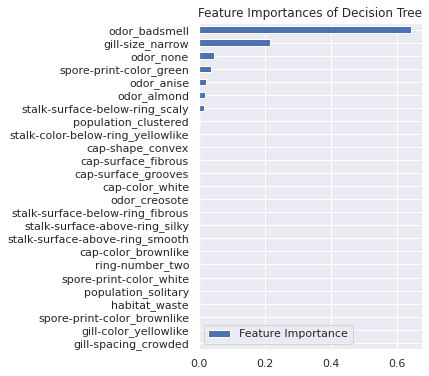

In [59]:
pd.DataFrame(dt[-1].feature_importances_, index=selected_features, columns=["Feature Importance"]).sort_values("Feature Importance").plot(kind="barh", figsize=(4, 6))
plt.title("Feature Importances of Decision Tree")
plt.savefig("fi.png", dpi=600)

When we plot the entire decision tree, we can see that the model values the odor of the mushroom most highly.

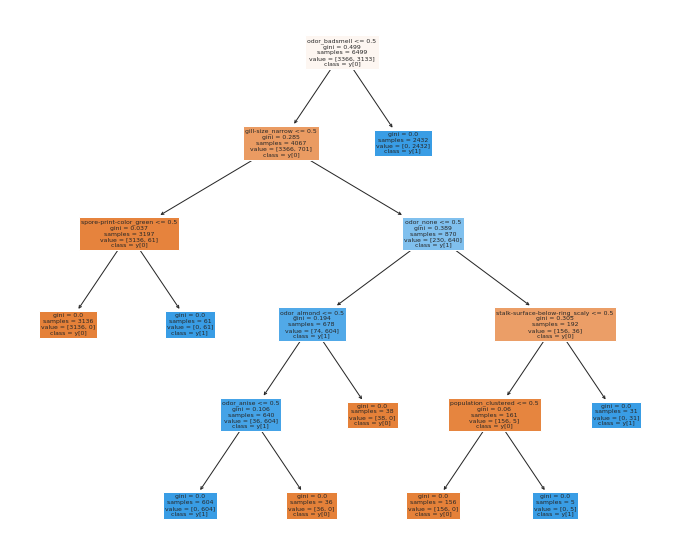

In [68]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_tree(dt[-1], feature_names=selected_features, filled=True, ax = ax, class_names=True)
fig.show()
plt.savefig("tree.png")

## Summary
We have successfully created a model that is able to predict if a mushroom is poisonous. Through extensive feature engineering and feature selection, we've been able to develop a simple model that succeeds in its goal of predicting if a mushroom is poisonous. However, the model still faces some limitations. It has only been trained and tested on synthetically generated data, and for only a few species of gilled mushroom. For the model to be truly deployable, it is necessary to collect more data samples, and to test it on real examples of mushrooms. Nevertheless, I've learnt a lot through this notebook such as designing custom scikit-learn transformers, and techniques for feature selection.